In [3]:
!pip install neurolab 

     |████████████████████████████████| 645 kB 5.8 MB/s 
  Created wheel for neurolab: filename=neurolab-0.3.5-py3-none-any.whl size=22179 sha256=45ee09107c2e2ef0ad0aef3de1baf7abb96702c5a56165bc31fa9a8866f16586
  Stored in directory: /root/.cache/pip/wheels/3e/07/63/e3d6e066089d7186465184a6f9a1884471485f38beef1edeaa
Successfully built neurolab


In [4]:
!pip install pyrenn

  Created wheel for pyrenn: filename=pyrenn-0.1-py3-none-any.whl size=9257 sha256=c03470a256c7a1db523690a5e918fc208d63a8758d4d4d1372f531efe1927140
  Stored in directory: /root/.cache/pip/wheels/00/36/ed/55abd022626413ad5e39d84b25cdd487f4ee8b38ba59e5aa29
Successfully built pyrenn


In [2]:
!pip install fireTS

In [10]:
import neurolab as nl
import numpy as np
import numpy.matlib
from sklearn.metrics import mean_squared_error
import pyrenn
from matplotlib import pyplot as plt
import math
import random
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
import fireTS

In [11]:
date = "1874-05-01"
a = 1.56
b = 3.12
R = [0, 1, 5] # delays

def g(k):
    return np.sin(np.sin(k) * k**3 - 10)

def u(k):
    return np.sin(k**2 - 7*k)

def f(k):
    y = [0.]
    for i in k:
        y.append(y[-1] / (1 + y[-1]**2) + u(i)**3)
    return y[:-1]

In [33]:
df = pd.read_csv('https://wwwbis.sidc.be/silso/INFO/snmtotcsv.php', sep=';', header=None)
df.head()

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [35]:
df = df.iloc[:, 0:4]
df.drop([2], axis=1, inplace=True)

df[0] = df[0].astype(str)
df[1] = df[1].astype(str)
df.index = pd.to_datetime(df[0] + '-' + df[1])

df.drop([0], axis=1, inplace=True)
df.drop([1], axis=1, inplace=True)

df.head()

,3
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7


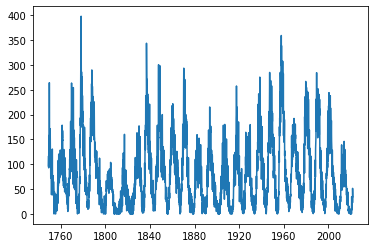

In [36]:
plt.plot(df)

In [43]:
values = df.values.flatten()

In [44]:
def smooth(a, windowWidth):
    out0 = np.convolve(a, np.ones(windowWidth, dtype=int), 'valid') / windowWidth    
    r = np.arange(1, windowWidth-1,2)
    start = np.cumsum(a[:(windowWidth-1)-1])[::2] / r
    stop = (np.cumsum(a[:-(windowWidth-1):-1])[::2] / r)[::-1]
    return np.concatenate((start, out0, stop))

In [45]:
smoothValues = smooth(values, 12)

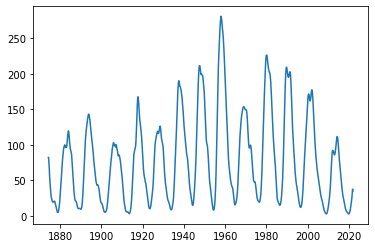

In [46]:
shift = df.values.size - smoothValues.size
df.iloc[shift:] = smoothValues[:, np.newaxis]

df = df[df.index >= pd.to_datetime(date)]

plt.plot(df)

In [140]:
trainSize = int(len(df) * 0.7)
train = df[:trainSize]
test = df[trainSize:]

X_train = train.index
y_train = train.values

X_test = test.index
y_test = test.values

In [144]:
X_train = X_train.strftime("%Y-%m-%d")
X_test = X_test.strftime("%Y-%m-%d")

In [183]:
X_t = []
for x in X_train:
  X_t.append(int(x.replace("-", "")))

In [145]:
y_train = y_train.reshape((1239,))

In [184]:
nn = pyrenn.CreateNN([1, 8, 1], dIn=[0], dIntern=[5]) #dIn - заддержки ввода; 

nn = pyrenn.train_LM(np.array(X_t), y_train, nn, E_stop=1e-5, k_max=600)

Maximum number of iterations reached


In [185]:
output = pyrenn.NNOut(np.array(X_t), nn)
MSE = mean_squared_error(output, y_train)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 2053.8661761905146
RMSE = 45.319600353384786


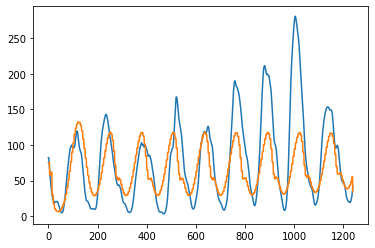

In [186]:
plt.plot(y_train)
plt.plot(output)

In [187]:
X_t = []
for x in X_test:
  X_t.append(int(x.replace("-", "")))

In [188]:
output = pyrenn.NNOut(np.array(X_t), nn)
MSE = mean_squared_error(output, y_test)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 36431.80089910292
RMSE = 190.87116308940676


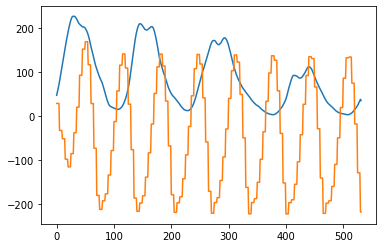

In [189]:
plt.plot(y_test)
plt.plot(output)

In [212]:
#2 задание
h = 0.025
r = [3, 0, 5]
k1 = np.linspace(0, 1, int(1 / h), endpoint=True)
k2 = np.linspace(1.12, 3.6, int(3.6 / h), endpoint=True)

In [191]:
t1 = np.ones(len(k1)) * (-1)
t2 = np.ones(len(k2))

In [192]:
def g(k):
  return np.sin(2*k*k - 6*k - np.pi)

p1 = np.sin(math.pi * 4 * k1)

p2 = g(k2)

In [193]:
p2 = p2.reshape(1, p2.shape[0])
t2 = t2.reshape(1, t2.shape[0])

In [213]:
from numpy import matlib
P = np.concatenate((matlib.repmat(p1, 1, r[0]), p2, matlib.repmat(p1, 1, r[1]), p2, matlib.repmat(p1, 1, r[2]), p2), axis=1).reshape(-1, 1)

T = np.concatenate((matlib.repmat(t1, 1, r[0]), t2,matlib.repmat(t1, 1, r[1]), t2, matlib.repmat(t1, 1, r[2]), t2), axis=1).reshape(-1, 1)

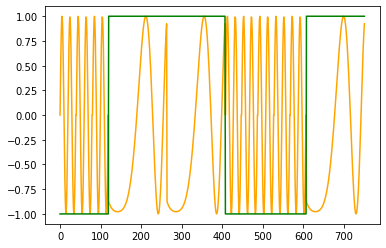

In [214]:
plt.plot(P.reshape(P.shape[0]), color='orange')
plt.plot(T.reshape(T.shape[0]), color='green')

In [215]:
P = P.reshape((752, ))
T = T.reshape((752, ))

In [217]:
nn = pyrenn.CreateNN([1, 8, 1], dIn=[5], dIntern=[5]) #dIn - заддержки ввода; 

nn = pyrenn.train_LM(P, T, nn, E_stop=1e-5, k_max=300)

Maximum number of iterations reached


In [218]:
output = pyrenn.NNOut(P, nn)

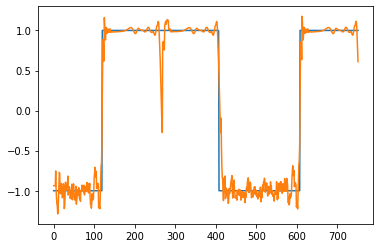

In [219]:
plt.plot(T)
plt.plot(output)

In [220]:
output[output >= 0] = 1.0
output[output < 0] = -1.0

MSE = mean_squared_error(T.reshape(T.shape[0]), output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.026595744680851064
RMSE = 0.16308201826336055


In [221]:
r[1] = 7
P = np.concatenate((matlib.repmat(p1, 1, r[0]), p2, matlib.repmat(p1, 1, r[1]), p2, matlib.repmat(p1, 1, r[2]), p2), axis=1).reshape(-1, 1)

T = np.concatenate((matlib.repmat(t1, 1, r[0]), t2,matlib.repmat(t1, 1, r[1]), t2, matlib.repmat(t1, 1, r[2]), t2), axis=1).reshape(-1, 1)

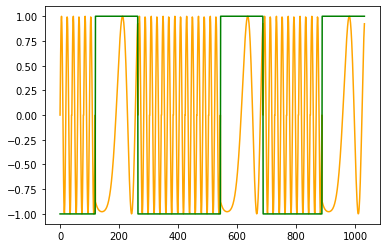

In [222]:
plt.plot(P.reshape(P.shape[0]), color='orange')
plt.plot(T.reshape(T.shape[0]), color='green')

In [224]:
P = P.reshape((1032,))

In [225]:
output2 = pyrenn.NNOut(P, nn)

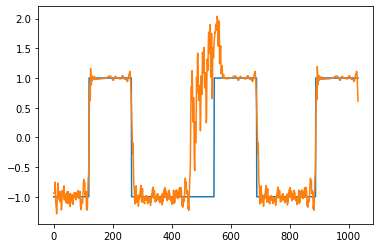

In [226]:
plt.plot(T)
plt.plot(output2)

In [227]:
#3 задание
k = np.linspace(0, 10, (int)(10/0.01))

def u(k):
    return np.sin(k**2 - 7*k)

def f(k):
    y = [0.]
    for i in k:
        y.append(y[-1] / (1 + y[-1]**2) + u(i)**3)
    return y[:-1]

y = f(k)
inpt = u(k)[:, np.newaxis]
target = y
# data parameters:
delay = 3
trainSize = 700
testSize = 200
validSize = 97
shift=10

xTrain = k[:700]
xTest = k[700:900]
xValid = k[900:997]

yTrain = y[:700]
yTest = y[700:900]
yValid = y[900:997]

In [246]:
!pip install sklearn

In [259]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y
from fireTS.utils import shift, MetaLagFeatureProcessor
from sklearn.model_selection import GridSearchCV
class TimeSeriesRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, **base_params):
        self.base_estimator = base_estimator.set_params(**base_params)

    def set_params(self, **params):
        for param, value in params.items():
            if param in self.get_params():
                super(TimeSeriesRegressor, self).set_params(**{param: value})
            else:
                self.base_estimator.set_params(**{param: value})
        return self 

class GeneralAutoRegressor(TimeSeriesRegressor, RegressorMixin):

    def __init__(self,
                 base_estimator,
                 auto_order,
                 exog_order,
                 exog_delay=None,
                 pred_step=1,
                 **base_params):
        super(GeneralAutoRegressor, self).__init__(base_estimator,
                                                   **base_params)
        self.auto_order = auto_order
        self.exog_order = exog_order
        if exog_delay is None:
            exog_delay = [0] * len(exog_order)
        if len(exog_delay) != len(exog_order):
            raise ValueError(
                'The length of exog_delay must be the same as the length of exog_order.'
            )
        self.exog_delay = exog_delay
        self.num_exog_inputs = len(exog_order)
        self.pred_step = pred_step

    def fit(self, X, y, **params):
        X, y = self._check_and_preprocess_X_y(X, y)
        features, target = self._preprocess_data(X, y)
        self.base_estimator.fit(features, target, **params)

    def _preprocess_data(self, X, y):
        p = self._get_lag_feature_processor(X, y)
        features = p.generate_lag_features()
        target = shift(y, -self.pred_step)

        # Remove NaN introduced by shift
        all_data = np.concatenate([target.reshape(-1, 1), features], axis=1)
        mask = np.isnan(all_data).any(axis=1)
        features, target = features[~mask], target[~mask]
        return features, target

    def _get_lag_feature_processor(self, X, y):
        return MetaLagFeatureProcessor(X, y, self.auto_order, self.exog_order,
                                       self.exog_delay)

    def grid_search(self, X, y, para_grid, **params):
        grid = GridSearchCV(self.base_estimator, para_grid, **params)
        X, y = self._check_and_preprocess_X_y(X, y)
        features, target = self._preprocess_data(X, y)
        grid.fit(features, target)
        self.set_params(**grid.best_params_)

    def _predictNA(self, Xdata):
        # Xdata contains nan introduced by shift
        ypred = np.empty(Xdata.shape[0]) * np.nan
        mask = np.isnan(Xdata).any(axis=1)
        X2pred = Xdata[~mask]
        ypred[~mask] = self.base_estimator.predict(X2pred)
        return ypred

    def _check_and_preprocess_X_y(self, X, y):
        min_samples_required = max(self.auto_order, 
                np.max(np.array(self.exog_delay) + np.array(self.exog_order))) - 1
        X, y = check_X_y(X, y, ensure_min_samples=min_samples_required)
        if len(self.exog_order) != X.shape[1]:
            raise ValueError(
                'The number of columns of X must be the same as the length of exog_order.'
            )
        return X, y

class NARX(GeneralAutoRegressor):
    def __init__(self,
                 base_estimator,
                 auto_order,
                 exog_order,
                 exog_delay=None,
                 **base_params):
        super(NARX, self).__init__(
            base_estimator,
            auto_order,
            exog_order,
            exog_delay=exog_delay,
            pred_step=1,
            **base_params)

    def score(self, X, y, step=1, method="r2"):
        ypred = self.predict(X, y, step=step)
        mask = np.isnan(y) | np.isnan(ypred)
        if method == "r2":
            return r2_score(y[~mask], ypred[~mask])
        elif method == "mse":
            return mean_squared_error(y[~mask], ypred[~mask])

    def predict(self, X, y, step=1):
        X, y = self._check_and_preprocess_X_y(X, y)
        p = self._get_lag_feature_processor(X, y)
        features = p.generate_lag_features()

        for k in range(step):
            yhat = self._predictNA(features)
            if k == step - 1:
                break
            features = p.update(yhat)

        ypred = np.concatenate([np.empty(step) * np.nan, yhat])[0:len(y)]
        return ypred

    def forecast(self, X, y, step=1, X_future=None):
        assert step > 0

        X, y = self._check_and_preprocess_X_y(X, y)

        if X_future is None:
            X_future = np.zeros((step - 1, self.num_exog_inputs))
        X_future = check_array(X_future, ensure_min_samples=0)
        if X_future.shape[0] != step - 1:
            raise ValueError('The row number of X_future ({}) must to step - 1 ({})!'.format(X_future.shape[0], step - 1))

        auto_regressor = deque(y[:(-1 - self.auto_order):-1])
        exog_regressors = [
                deque(X[(-1 - d):(-1 - d - q):-1, i])
                for i, (d, q) in enumerate(zip(self.exog_delay, self.exog_order))
                ]
        cur_step = 0
        y_forecast = []
        while cur_step < step:
            X_base = np.concatenate([np.array(auto_regressor), 
                np.concatenate(exog_regressors)]).reshape(1, -1)
            y_hat = self.base_estimator.predict(X_base)
            y_forecast.append(y_hat[0])
            if cur_step == step - 1:
                break
            # update regressors with the newly obtained values
            auto_regressor.pop()
            auto_regressor.appendleft(y_forecast[-1])
            for exog_reg, X_next in zip(exog_regressors, X_future[cur_step, :]):
                exog_reg.pop()
                exog_reg.appendleft(X_next)
            cur_step += 1
        return np.array(y_forecast)


In [260]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,auto_order=2, exog_order=[2], exog_delay=[delay])

In [261]:
narx.fit(inpt, target)

In [266]:
output = narx.predict(inpt.reshape(-1, 1), target, step=1)

output[np.isnan(output)] = 0
MSE = mean_squared_error(target, output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.00018018168863415308
RMSE = 0.01342317729280788


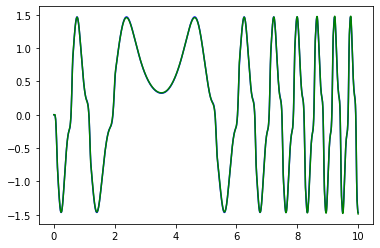

In [267]:
plt.plot(k, y, color='blue')
plt.plot(k, output, color='green')

In [268]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600, auto_order=2, exog_order=[delay], exog_delay=[delay])
narx.fit(inpt, target)

In [269]:
inputTest = u(xTest)[:, np.newaxis]
targetTest = yTest
outputTest = narx.predict(inputTest, targetTest, step=3)

In [270]:
outputTest[np.isnan(outputTest)] = 0
MSE = mean_squared_error(targetTest, outputTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.008025981352681868
RMSE = 0.0895878415449433


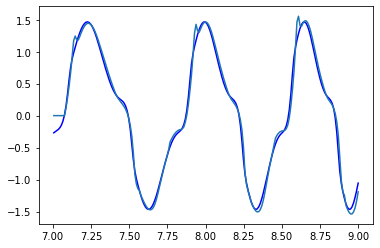

In [272]:
plt.plot(xTest, yTest, color='blue')
plt.plot(xTest, outputTest)